In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from xbbg import blp
from datetime import datetime

start_date = '2023-01-01'  # Adjust the start date as needed
end_date = datetime.today().strftime('%Y-%m-%d')  # Convert today's date to 'YYYY-MM-DD' format

df1 = blp.bdh('9988 HK Equity', 'PX_LAST', start_date, end_date, FX='USD')
df2 = blp.bdh('BABA US Equity', 'PX_LAST', start_date, end_date, FX='USD')

# Continue with your data processing and analysis
# Prepare the dataframes
df1.reset_index(inplace=True)
df2.reset_index(inplace=True)
df1.columns = ['Date', 'Adj Close']
df2.columns = ['Date', 'Adj Close']
df=pd.merge(df1, df2, on='Date', suffixes=('_9988', '_BABA'))
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
trainset=np.arange(0, 252)
testset=np.arange(trainset.shape[0], df.shape[0])

#Determine hedge ratio
model=sm.OLS(df.loc[:, 'Adj Close_9988'].iloc[trainset], df.loc[:, 'Adj Close_BABA'].iloc[trainset])
results=model.fit()
hedgeRatio=results.params
print(hedgeRatio)

Adj Close_BABA    0.124825
dtype: float64


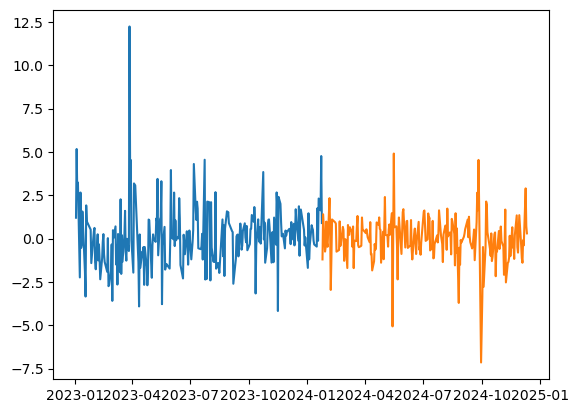

In [2]:
spread=df.loc[:, 'Adj Close_BABA']- 8 *df.loc[:, 'Adj Close_9988']
plt.plot(spread.iloc[trainset])
plt.plot(spread.iloc[testset])
spreadMean=np.mean(spread.iloc[trainset])
spreadMean
spreadStd=np.std(spread.iloc[trainset])
spreadStd
df['zscore']=(spread-spreadMean)/spreadStd

df['positions_BABA_Long']=0
df['positions_9988_Long']=0
df['positions_BABA_Short']=0
df['positions_9988_Short']=0

df.loc[df.zscore>=2, ('positions_BABA_Short', 'positions_9988_Short')]=[-1, 1] # Short spread
df.loc[df.zscore<=-2, ('positions_BABA_Long', 'positions_9988_Long')]=[1, -1] # Buy spread
df.loc[df.zscore<=1, ('positions_BABA_Short', 'positions_9988_Short')]=0 # Exit short spread
df.loc[df.zscore>=-1, ('positions_BABA_Long', 'positions_9988_Long')]=0 # Exit long spread